EDA To Prediction (DieTanic)을 보고 필사했습니다. - https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook

---

> 삶은 때론 잔인한 유머 감각을 가집니다.
> 
> 삶은 당신이 항상 원했던 것을 가장 최악의 시간에 가지게 합니다.

타이타닉의 침몰은 역사 상 가장 악명 높은 난파 중 하나입니다. 

1912년 4월 15일, 타이타닉의 첫번째 항해에서 타이타닉은 빙산과 부딪친 후 가라 앉았는데, 거기서 총 2224명의 승객과 선원 중 1502명이 사망했습니다. 그래서 "DieTanic"이라고도 불리는 이유가 바로 이 때문입니다. 정말 잊을 수 없는 재난이고, 세계 어느 누구도 잊을 수 없습니다. 

타이타닉을 모두 짓는데 750만 달러 가까이 들었고, 충돌 때문에 바다 아래로 가라앉았습니다. 타이타닉 데이터셋은 데이터 사이언스를 탐험하고 Kaggle 경쟁에 참여를 시작하는 초심자에게 매우 좋은 데이터셋입니다.

이 노트북 목적은 모든 예측 모델링 문제의 workflow가 어떤 것인지 아이디어를 제공하는 것입니다. 어떻게 feature들을 체크하고, 어떻게 새로운 features들과 몇몇 머신 러닝 컨셉을 추가하는지. 나는 어떤 초심자도 모든 맥락을 이해할 수 있도록 노트북을 가능한한 기초적으로 하려고 노력해왔습니다. 

만일 당신이 이 노트북을 좋아하고 당신에게 도움을 줬다고 생각한다면, UPVOTE 해주세요. 
이것은 제게 동기를 일으켜줍니다.

# 목차

**Part1: 데이터 분석 탐험(EDA)**

1. feature들을 분석
2.  여러 feature들을 고려해서 어떤 관계, 트랜드가 있는지 찾음

**Part2: Feature 엔지니어링 & 데이터 클린징**

1. feature를 추가
2. 장황한 feature들은 제거
3. 모델에 적합한 형식으로 feature들을 변환

**Part3: 모델로 예측하기**

1. 기본 알고리즘 돌리기
2. Cross Validation
3. Ensembling
4. 중요한 feature 추출



# Part1: 데이터 분석 탐험(EDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/colab/data-analysis-practice/data/01_titanic/train.csv')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# 전체에서 null 값이 있는지 확인

data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Age, Cabin, Embarked**가 null 값입니다. 이를 수정할 예정입니다.

## 얼마나 생존했을까?

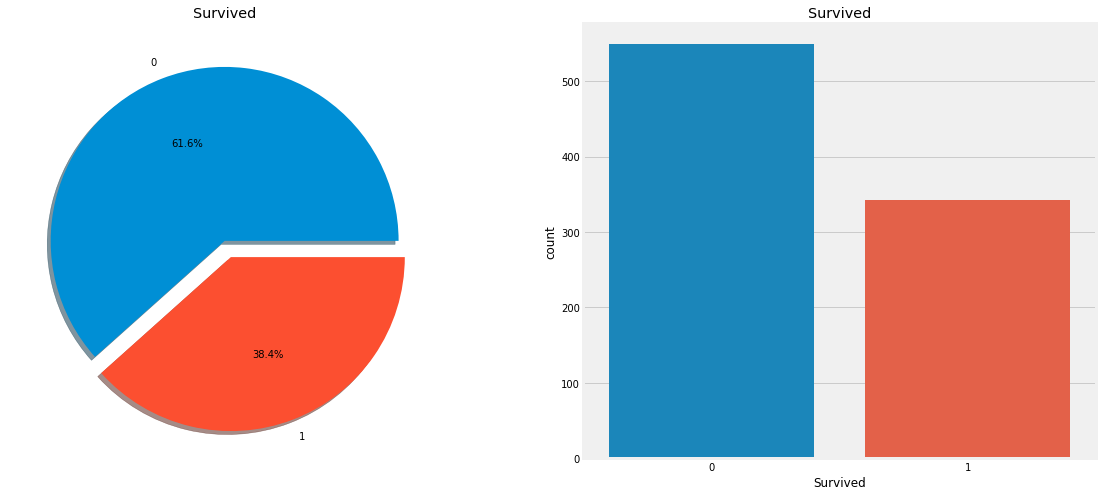

In [6]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

survived = data['Survived'].value_counts()
survived.plot.pie(
    explode=[0, 0.1], 
    autopct='%1.1f%%', 
    ax=ax[0], 
    shadow=True
)

ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()



많은 승객들이 사고에서 생존하지 않았던 사고입니다.

training dataset에서 891명이 넘는 승객들이 생존하지 않았고, 오직 38.4%인 350명만이 생존했습니다. 우리는 더 나은 인사이트를 얻고 동시에 어떤 승객들이 생존했는지 아닌지를 보기 위해 데이터를 더 파볼 필요가 있습니다.

우리는 데이터셋의 각기 다른 feature들을 사용해서 생존율을 확인할 예정입니다. 몇몇 feature들은 성별, 승선항, 나이 등입니다.

먼저 feature들의 type들을 이해해봅시다.

## Features의 Type들

**Categorical Features (범주형 features)**
- 범주형 값은 두개 이상의 범주가 있고 해당 feature의 각 값을 범주별로 분류할 수 있는 값입니다.
- 예를 들어, 성별은 (남/여) 두 범주를 가지는 범주형 값입니다.
- 정렬할 수 없거나 각 값에 어떤 순서도 없습니다.
- "Nominal Variables(명목변수)"라고 부르기도 합니다.
- 데이터셋에서 범주형 feature들 : Sex, Embarked

**Ordinal Features (순서형 features)**
- 순서형 값은 범주형 값과 비슷하지만, 차이점은 값 간의 상대적인 순서 또는 정렬을 가질 수 있다는 것입니다.
- 만일 "Tall, Medium, Short"값을 가지는 Height(높이) feature를 가진다면, Height는 순서형 값입니다. 여기서 값에 상대적인 정렬을 가질 수도 있습니다.
- 데이터셋에서 순서형 feature들 : PClass

**Continous Features (연속형 features)**
- 어떤 두 포인트 사이에 값들을 가지거나 최소/최대 값들 사이에 값들을 가질 수 있다면 연속형 features라고 말합니다.
- 데이터셋에서 연속형 feature들 : Age

## Feature들 분석

### Sex -> 범주형 feature

In [7]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

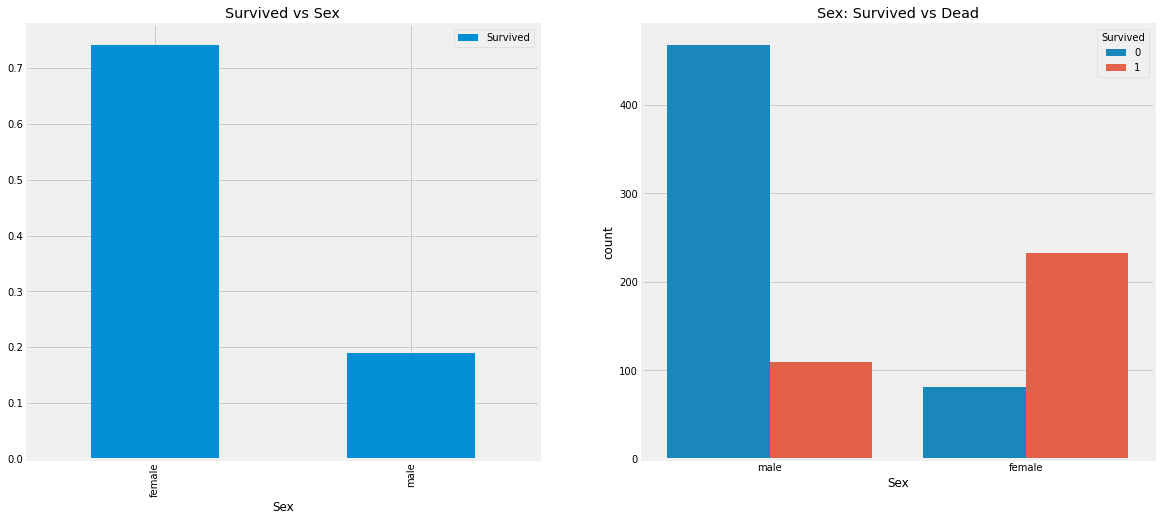

In [8]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

sns.countplot('Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')

plt.show()

이부분이 흥미롭네요.

배에 탑승한 남성의 수가 여성의 수보다 더 많습니다. 여전히 구해진 여성의 수가 거의 남성의 수보다 두배이구요. 이 배에서 여성의 생존율은 (남성이 18-19%인데 반해) 약 75%입니다. 

이건 모델링에서 매우 중요한 feature로 보입니다. 그러나 이것뿐이면 될까요? 다른 feature들도 살펴보겠습니다.

### Pclass -> 순서형 feature

In [9]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


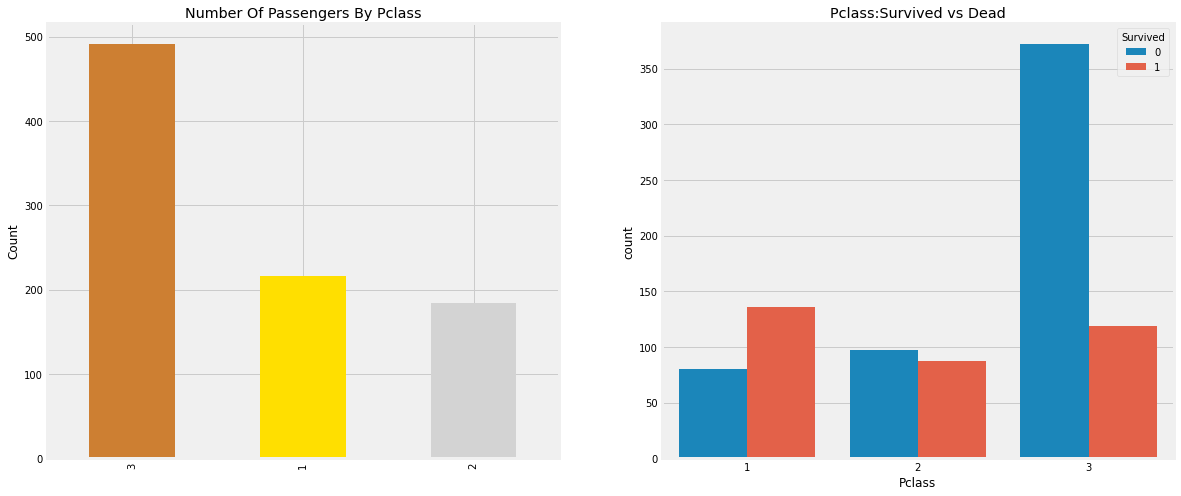

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot('Pclass', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')

plt.show()

사람들은 돈으로 모든걸 살 순 없다고 말합니다. 그러나 우리는 Pclass 1 승객들이 구조에 매우 높은 우선순위를 가지고 있음을 명백하게 볼 수 있습니다. 심지어 Pclass 3의 승객들의 수가 더 많음에도 불구하고, Pclass 3에서 생존자 수는 약 25%를 맴돌고 있습니다.

Pclass 1의 생존율은 약 63%, Pclass 2는 약 48%입니다. 그래서 돈과 지위는 상관이 있습니다. 물질만능주의 세상이네요.

조금 더 파고들어서 다른 흥미로운 관찰들을 해봅시다. Sex와 Pclass를 가지고 함께 생존율을 확인해봐요.

In [11]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')

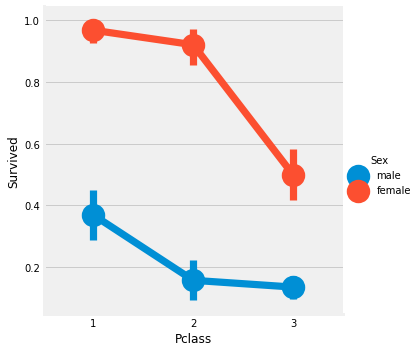

In [12]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=data)
plt.show()

범주형 값을 쉽게 분리할 수 있기 때문에 우리는 이 케이스에서 FactorPlot을 사용합니다.

CrossTab과 FactorPlot을 보면 Pclass 1 여성에 대한 생존율이 약 95-96%라고 쉽게 추론할 수 있습니다.

Pclass에 관계없이, 여성들은 구조에 있어서 첫번째 우선순위로 주어진다는 사실은 명백합니다. 심지어 Pclass1의 남성은 매우 낮은 생존율을 가집니다.

Pclass와 같은 양상은 중요한 feature입니다. 그럼 다른 feature들을 분석해볼까요.

### Age -> 연속형 feature

In [13]:
print('Oldest Passenger was of : ', data['Age'].max(), 'Years')
print('Youngest Passenger was of : ', data['Age'].min(), 'Years')
print('Average Passenger was of : ', data['Age'].mean(), 'Years')

Oldest Passenger was of :  80.0 Years
Youngest Passenger was of :  0.42 Years
Average Passenger was of :  29.69911764705882 Years


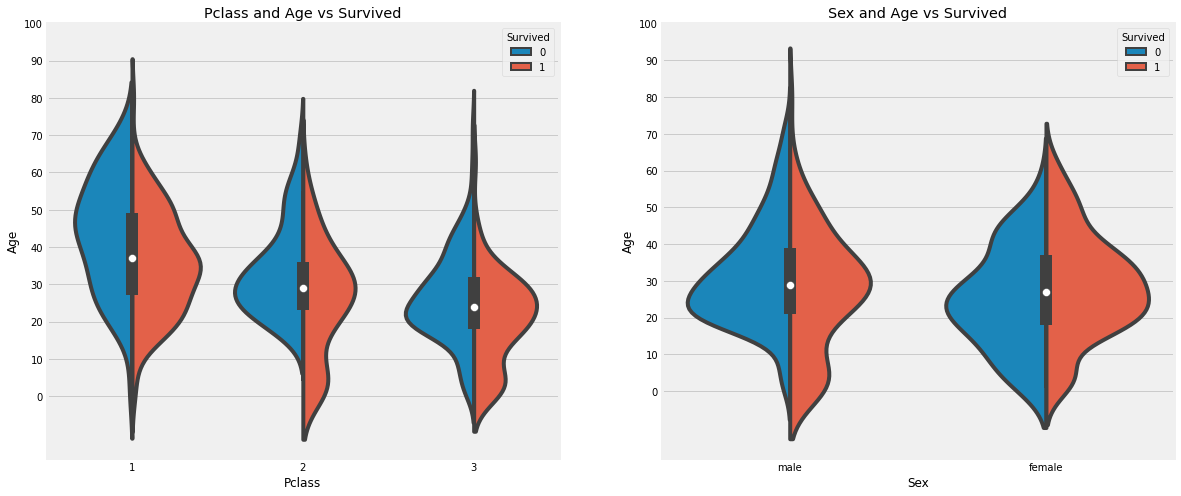

In [14]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot('Pclass', 'Age', hue='Survived', data=data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot('Sex', 'Age', hue='Survived', data=data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

**Observations:**

1. 아이들 수는 Pclass에 따라 증가하고 10살 이하 승객 생존율은 Pclass와 상관없이 좋아 보입니다.

2. Pclass1의 20-50살인 승객들의 생존 기회는 높고 심지어 여성보다 더 낫습니다.

3. 남성은 나이가 증가할수록 생존 기회가 감소합니다.

우리는 일찍이 먼저 봤던 것처럼, Age feature는 177개의 null 값을 가지고 있었습니다. 이 NaN 값들을 대체하기 위해, 우리는 데이터셋의 평균 나이를 할당할 수 있습니다.

그러나 문제로, 많은 다양한 나이를 가진 많은 사람들이 있다는 겁니다. 우리는 단순히 4살 아이에게 평균 나이인 29살을 할당할 순 없습니다. 어떤 다른 방법은 없을까요?

Bingo! 우리는 Name feature를 확인할 수 있습니다. 해당 feature를 살펴보면, 이름은 Mr or Mrs와 같은 인사말이 있는걸 볼 수 있습니다. 따라서 각 그룹에 Mr와 Mrs의 평균 값을 할당할 수 있어요.

In [15]:
data['Initial'] = 0
for i in data:
  data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.') # Mr 또는 Mrs를 추출

In [16]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


그럼 여기서 Miss..?일 것으로 보이는 Mlle나 Mme와 같은 몇가지 오타들이 있습니다. 이들을 Miss로 변경하고 다른 값들은 같은 것으로 대체하겠습니다.

In [17]:
data['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don'], 
                        ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr'], inplace=True)

In [18]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### NaN Age 값 채우기

In [19]:
data.loc[(data.Age.isnull())&(data.Initial=='Mr'), 'Age'] = 33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'), 'Age'] = 36
data.loc[(data.Age.isnull())&(data.Initial=='Master'), 'Age'] = 5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'), 'Age'] = 22
data.loc[(data.Age.isnull())&(data.Initial=='Other'), 'Age'] = 46

In [20]:
# 남아있는지 확인

data.Age.isnull().any()

False

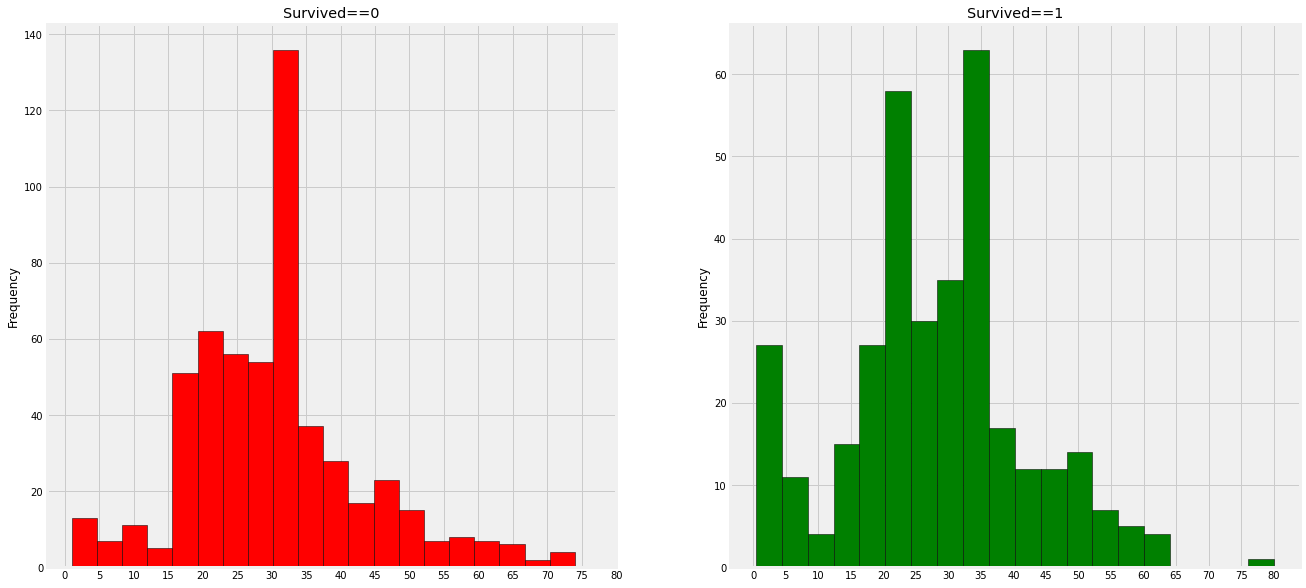

In [21]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

data[data['Survived']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='red')
ax[0].set_title('Survived==0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

data[data['Survived']==1].Age.plot.hist(ax=ax[1], bins=20, edgecolor='black', color='green')
ax[1].set_title('Survived==1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)

plt.show()

**Observations:**
1. 영유아(5세 미만)들이 정말 많이 구해졌다.(여성과 아이는 첫번째 정책에 의해)
2. 가장 늙은 승객은 살았다. (80살)
3. 가장 많이 죽은 수는 30-40세 그룹이다.

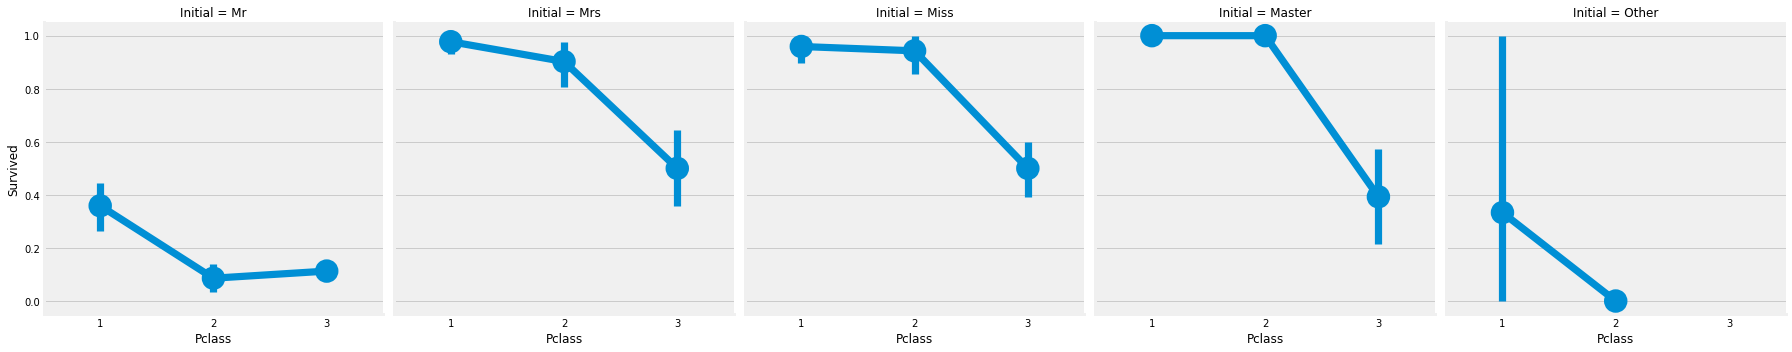

In [22]:
sns.factorplot('Pclass', 'Survived', col='Initial', data=data)
plt.show()

여성과 아이 첫번째 정책은 Pclass에 관계없다는 것이 참이다.

### Embarked -> 범주형 값

In [23]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient(cmap='summer_r')

#### Port of Embarkation에 의한 생존 기회

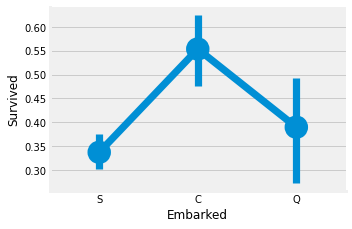

In [24]:
sns.factorplot('Embarked', 'Survived', data=data)
fig = plt.gcf() # Get the current figure.
fig.set_size_inches(5,3)
plt.show()

Port C에 생존기회가 약 0.55로 가장 높고, 반면에 S는 가장 낮습니다.

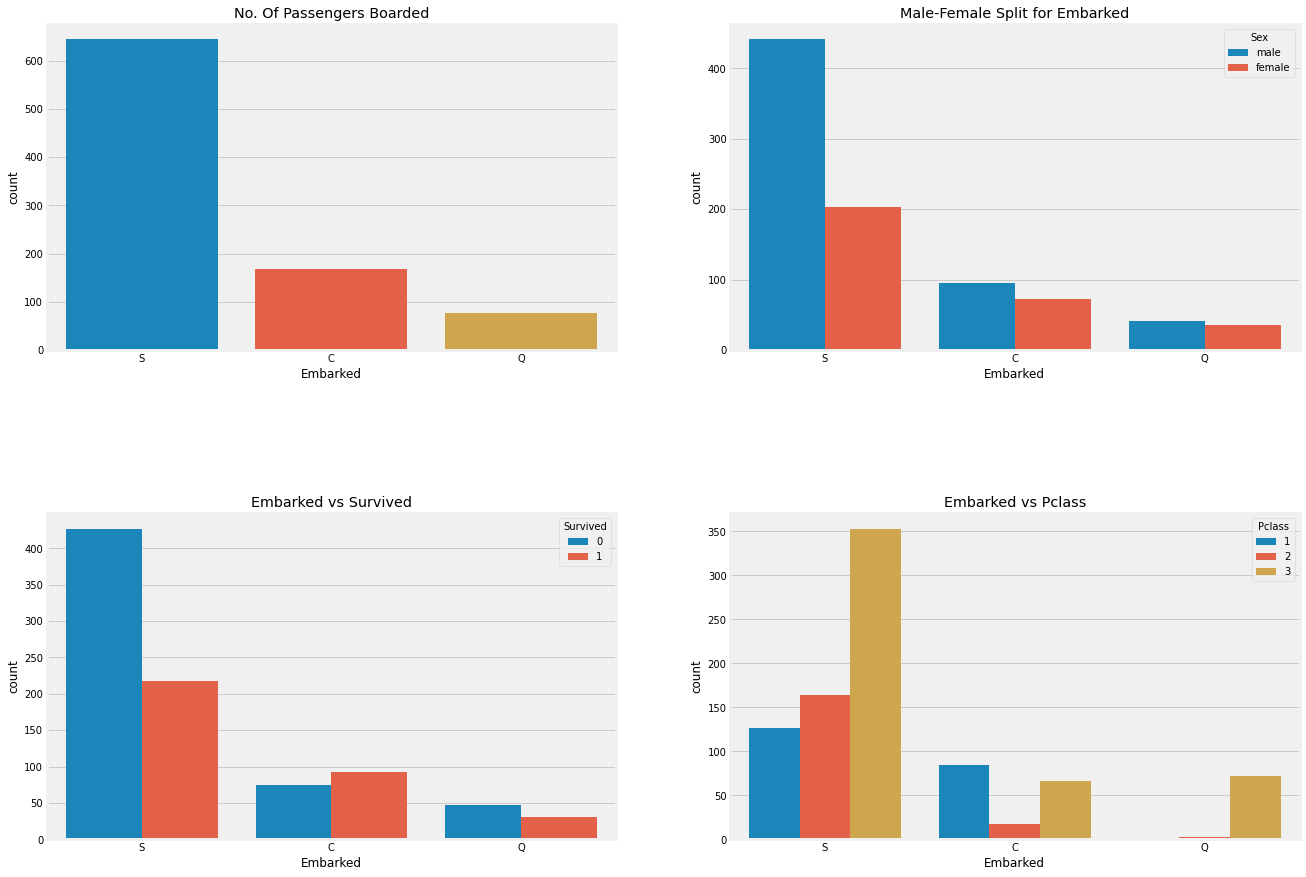

In [25]:
f, ax = plt.subplots(2, 2, figsize=(20,15))
sns.countplot('Embarked', data=data, ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=data, ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=data, ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=data, ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

**Observations:**

1. 가장 많은 승객들이 Pclass3의 대부분이 S 로부터 탑승했다.
2. C에서 탑승한 승객들은 좋은 비율로 생존했기 때문에 운이 좋아 보입니다. 아마 이 이유는 Pclass1와 Pclass2 승객들 모두 구조되서 그런 것 같다.
3. S는 부유한 사람들이 탑승했던 항구로 보인다. 여전히 생존의 기회는 낮지만, 그건 Pclass3의 많은 승객들 (약 81%)이  생존하지 않았기 때문이다.

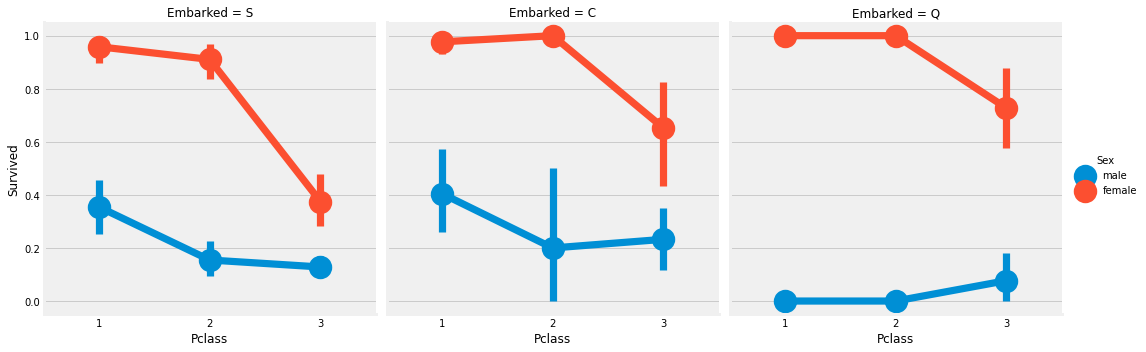

In [26]:
sns.factorplot('Pclass', 'Survived', hue='Sex', col='Embarked', data=data)
plt.show()

**Observations:**
1. Pclass1과 Pclass2에서 여성에게 생존 기회는 거의 1이다.
2. 남성 여성 모두 생존율이 매우 낮기 때문에, S 항구는 Pclass3 탑승객들에게 매우 운이 좋지 않았다. (Money Matters)
3. Q 항구는 남성에게 가장 불행했던 것으로 보입니다.

#### Embarked NaN 채우기

- S 항구에서 최다 승객들이 탑승한 것을 볼 수 있듯이, NaN을 S로 바꾸겠습니다.

In [27]:
data['Embarked'].fillna('S', inplace=True)

In [28]:
data.Embarked.isnull().any()

False

### SibSip -> 이산 Feature

- 이 feature는 한 사람이 혼자인지 가족과 함께인지 아닌지를 보여줍니다.
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife

In [29]:
pd.crosstab([data.SibSp], data.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


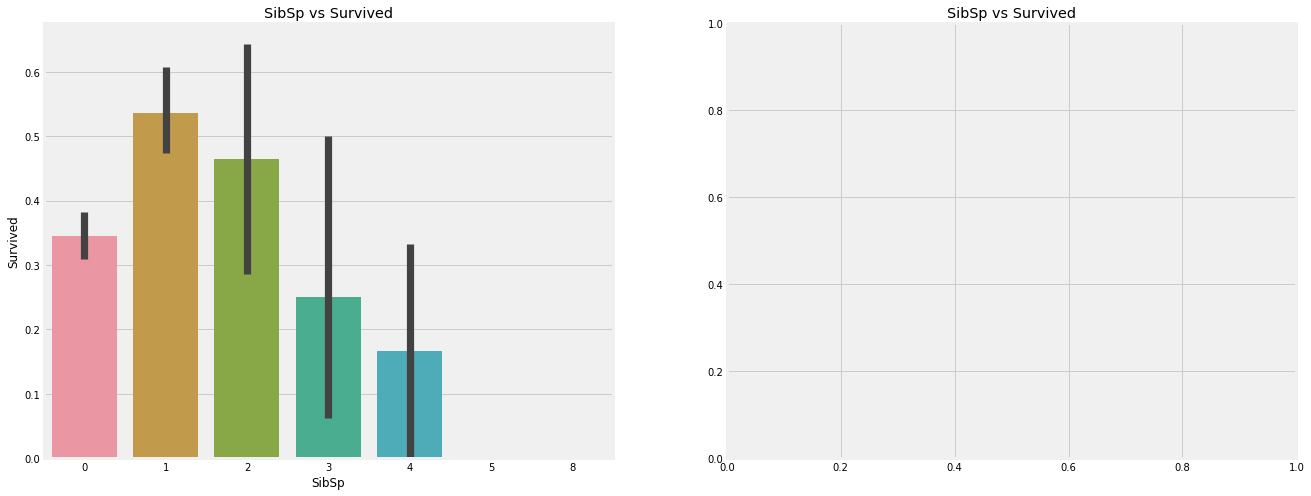

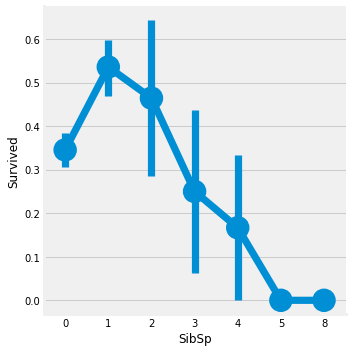

In [30]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
sns.barplot('SibSp', 'Survived', data=data, ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp', 'Survived', data=data, ax=ax[1])
ax[1].set_title('SibSp vs Survived')
# plt.close(2)
plt.show()

In [31]:
pd.crosstab(data.SibSp, data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


**Observations:**

barplot과 factorplot은 승객이 형제가 없이 혼자 탑승한 경우 34.5% 생존율임을 보여준다. 그 그래프는 형제 수가 증가하는 경우 급격하게 감소하는데 말이 되는 수치다. 
즉, 만일 내가 가족과 함께 탑승한다면, 내가 우선 살아남는 것 대신 가족을 살리려 노력할거다. 놀랍게도 가족이 5~8명인 생존율은 0%다. Pclass와 연관된 수치일까?

그렇다 이유는 Pclass이다. crosstab을 보면 SibSp>3인 사람은 모두 Pclass3이다. Pclass3에서 (3명 이상인) 대가족은 모두 죽었다.

### Parch

In [32]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


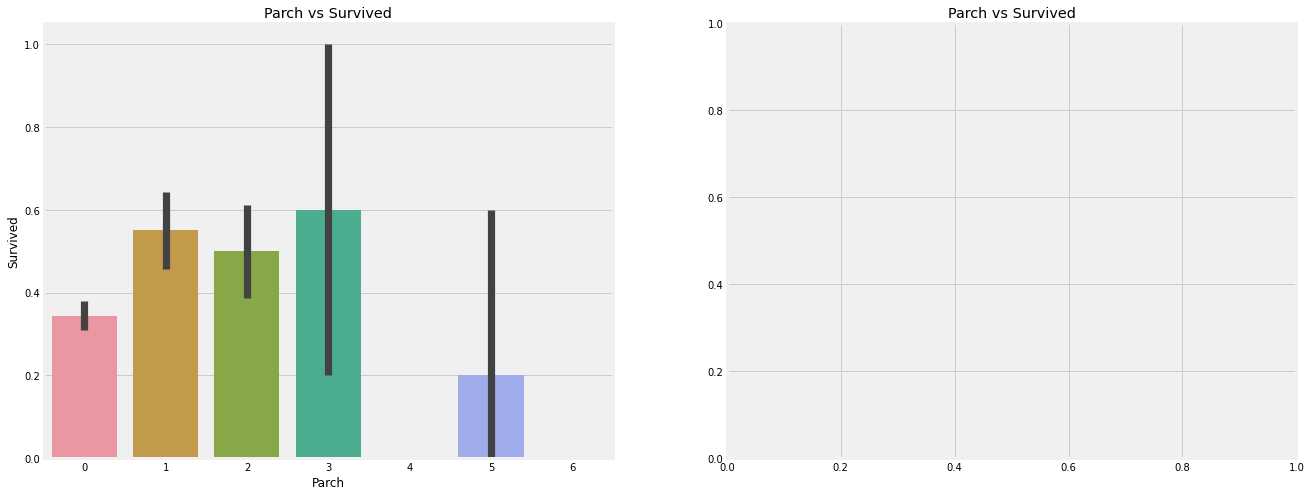

In [33]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot('Parch', 'Survived', data=data, ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch', 'Survived', data=data, ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

**Observations**
- 여기 결과가 꽤 비슷합니다. 부모와 함께 탑승한 승객들은 생존에 훨씬 더 많은 기회를 가집니다. 그러나 숫자가 올라갈수록 줄어듭니다.

- 생존의 기회는 배에 1~3명정도 부모를 가진 사람들에게 좋습니다. 혼자인 사람은 치명적임을 증명하고 또한 배에 4명 넘는 부모들을 가진 사람인 경우 생존기회가 감소합니다. 


### 요금 -> 연속 feature

In [34]:
print('Highest Fare was: ', data['Fare'].max())
print('Lowest Fare was: ', data['Fare'].min())
print('Average Fare was: ', data['Fare'].mean())

Highest Fare was:  512.3292
Lowest Fare was:  0.0
Average Fare was:  32.2042079685746


가장 낮은 요금은 0.0입니다. 공짜 호화 탑승이군요

Text(0.5, 1.0, 'Fares in Pclass 3')

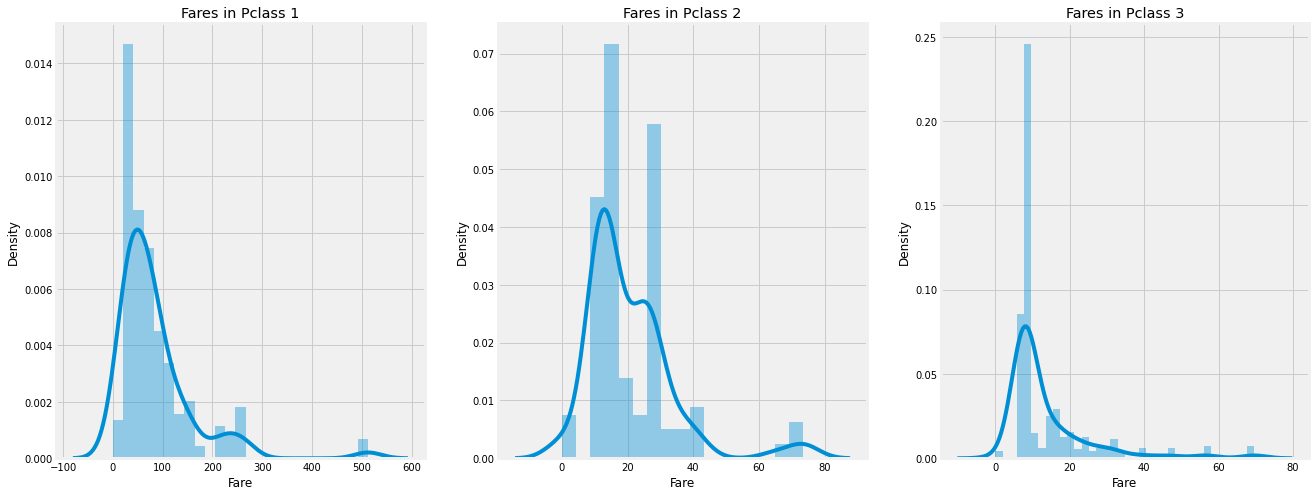

In [35]:
f, ax = plt.subplots(1, 3, figsize=(20,8))
sns.distplot(data[data['Pclass']==1].Fare, ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare, ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare, ax=ax[2])
ax[2].set_title('Fares in Pclass 3')

Pclass1에 승객 요금에서 큰 분포를 보여주고 있고, 이 분산은 표준이 감소함에 따라 계속 감소합니다. 이는 연속적이므로, binning을 사용해서 이산 값으로 변환할 수 있습니다.

### 모든 feature들의 간단 요약

- Sex : 여성의 생존 기회는 남성에 비해 높다.
- Pclass : 퍼스트 클래스 승객인 사람들은 생존에 기회가 더 낫다는 가시적인 트렌드가 있다. Pclass3은 생존 비율이 매우 낮다. 여성인 경우 Pclass1의 생존 기회는 거의 1이고 Pclass2에 여성들도 또한 높다. 돈이 최고다..!
- Age : 5~ 10세 이하의 아이들이 생존기회가 높다. 15~35세 사이 승객들이 많이 죽었다.
- Embarked : 이 feature는 흥미롭다. Pclass1의 주요 승객들이 S에 탑승함에도 불구하고 이보다 C에서 생존기회가 더 나은 것으로 보인다. Q의 승객들은 Pclass3에 모두 있다. 
- Parch+SibSp : 형제자매가 1~ 2명, 배우자가 있거나 부모가 1~3명인 경우 혼자이거나 대가족이 함께 여행하는 것보다 가능성이 더 높습니다.

### feature들 상관관계

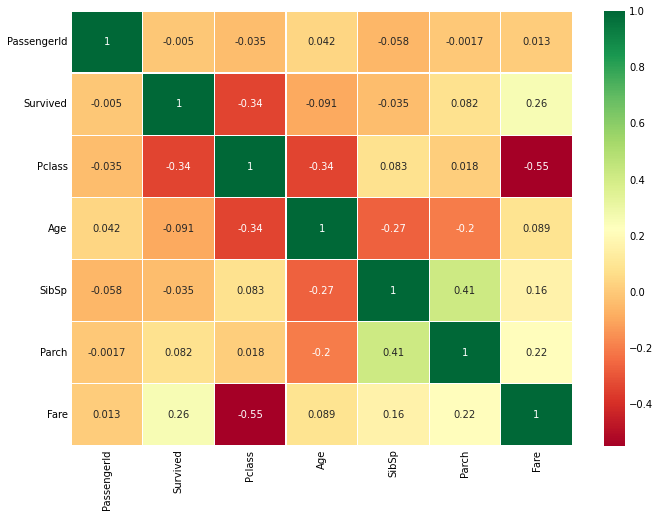

In [36]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10, 8)
plt.show()

### Heatmap 해석

첫번째 특징은 숫자형 feature만 비교된다는 점이고, 알파벳이나 문자열 사이의 상관관계를 할 수 없다는 점은 명백합니다. 이 heatmap을 이해하기 전에, 정확하게 무슨 상관관계인지 보도록 합니다.

- 양의 상관관계
  - 만일 feature A 증가하고 feature B도 증가하면 이들은 양의 상관관계입니다. 1 값은 완벽한 양의 상관관계를 의미합니다. 
- 음의 상관관계
  - 만일 feature A가 증가하고 feature B가 감소하면 이들은 음의 상관관계입니다. -1 값은 완벽한 음의 상관관계를 의미합니다.

자 이제[ 두 feature들은 매우 또는 완벽한 상관관계여서, 하나가 증가하고 다른 하나가 증가합니다. 이는 두 feature들 모두 매우 유사한 정보를 포함하고 있고 정보에 변동이 매우 적거나 거의 없다는 것을 의미합니다. 이는 두 feature들이 거의 동일한 정보를 포함하고 있다는 것으로, 다중공정성(MultiColinearity)이라 불립니다.

그래서 둘 중 하나가 중복되니 둘다 사용해야 할까요? 모델을 만들거나 훈련하는 동안, 우리는 중복 feature들을 줄이려고 노력해야 합니다. 학습 시간과 많은 이점들을 줄이도록,

이제 위에 heatmap으로부터, 우리는 feature들이 많은 상관관계가 있지 않다는걸 볼 수 있습니다. 가장 많은 상관관계는 SibSp과 Parch사이에 0.41입니다. 그래서 우리는 모든 feature들을 가지고 진행할 수 있습니다.

# Part2: Feature Engineering과 Data Cleaning

Feature Engineering은 뭘까요?

feature들을 가진 데이터셋이 주어질 때마다, 모든 feature들이 중요할 필요는 없습니다. 제거해야 하는 중복된 feature들이 많이 있을지도 모릅니다. 또한 다른 feature들로부터 정보를 도출하거나 추출해서 새로운 feature들을 가지고 추가할 수 있습니다.

## Age_band

Age feature 문제

Age는 연속 feature라고 일찍이 언급했던 것처럼 머신러닝 모델에서 연속 값 문제가 있습니다. 

예: 만일 성별로 스포츠 인원을 그룹화 또는 배치한다고 한다면, Male과 Female로 그들을 분리할 수 있습니다. 

Age로 그룹화를 해본다면, 어떻게 할까요? 만일 30명이 있으면, 30살 값들로 있을지도 모릅니다. 이게 바로 문제가 되죠

우리는 Binning이나 Normalisation으로 이 연속 값을 카테고리 값으로 변환할 필요가 있습니다. age 범주 그룹 각 그룹을 작은 상자에 담거나 단일 값으로 할당할 예정입니다.

자 그럼 승객의 최고 연령이 80이었죠. 0-80을 5 bin으로 범주를 나누겠습니다. 그러면 80/5 = 16 이죠. 그럼 bin 사이즈는 각각 16이 됩니다.

In [37]:
data['Age_band'] = 0
data.loc[data['Age']<=16, 'Age_band'] = 0
data.loc[(data['Age']>16)&(data['Age']<=32), 'Age_band'] = 1
data.loc[(data['Age']>32)&(data['Age']<=48), 'Age_band'] = 2
data.loc[(data['Age']>48)&(data['Age']<=64), 'Age_band'] = 3
data.loc[data['Age']>64, 'Age_band'] = 4
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


In [38]:
data['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,382
2,325
0,104
3,69
4,11


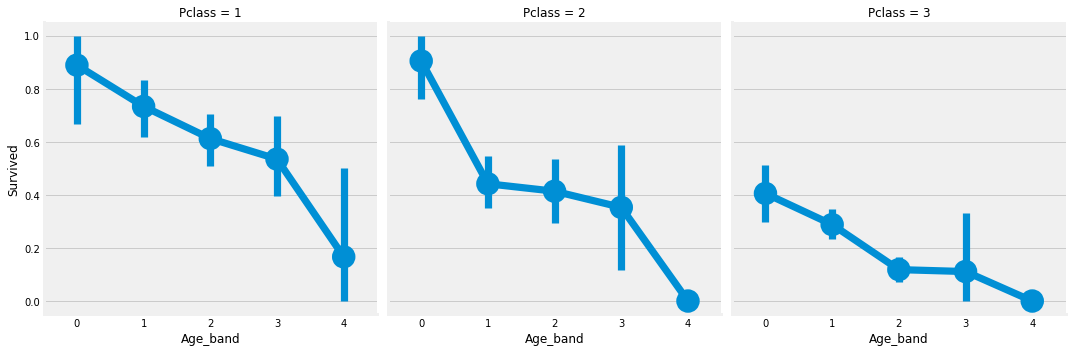

In [39]:
sns.factorplot('Age_band', 'Survived', data=data, col='Pclass')
plt.show()

사실... Pclass에 상관없이 나이가 증가함에 따라 생존율은 감소합니다.

## Family_Size and Alone

이 부분에서 우리는 'Family_size'와 'Alone'이라 불리는 새로운 feature를 생성하고 분석할 수 있습니다. 이 feature는 Parch와 SibSp의 요약입니다. 생존율이 승객 family size로 어떤 기능을 하는지 아닌지 체크하기 위한 결합된 데이터를 줍니다. Alone은 승객이 혼자인지 아닌지 나타낼 겁니다.

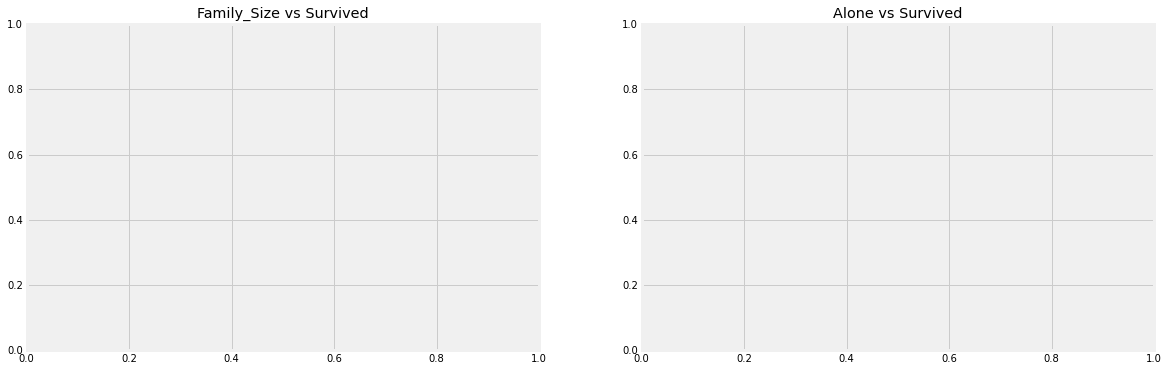

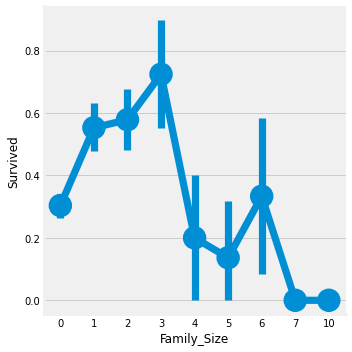

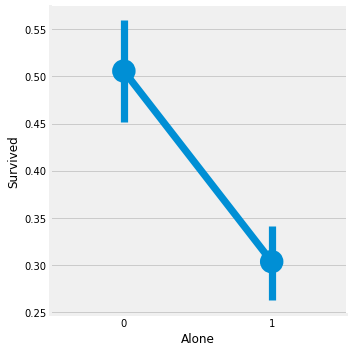

In [40]:
data['Family_Size'] = 0
data['Family_Size'] = data['Parch'] + data['SibSp']

data['Alone'] = 0
data.loc[data.Family_Size==0, 'Alone'] = 1

f,ax = plt.subplots(1, 2, figsize=(18,6))
sns.factorplot('Family_Size', 'Survived', data=data, ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone', 'Survived', data=data, ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.show()

Family_Size=0은 승객이 혼자라는 의미입니다. 명백히 혼자이거나 family_size=0이면, 생존 기회는 매우 낮습니다. family_size>4인 사람들도 생존 기회는 감소합니다. 이는 모델에 중요한 feature로 보여집니다. 다음을 보며 설명하겠습니다.

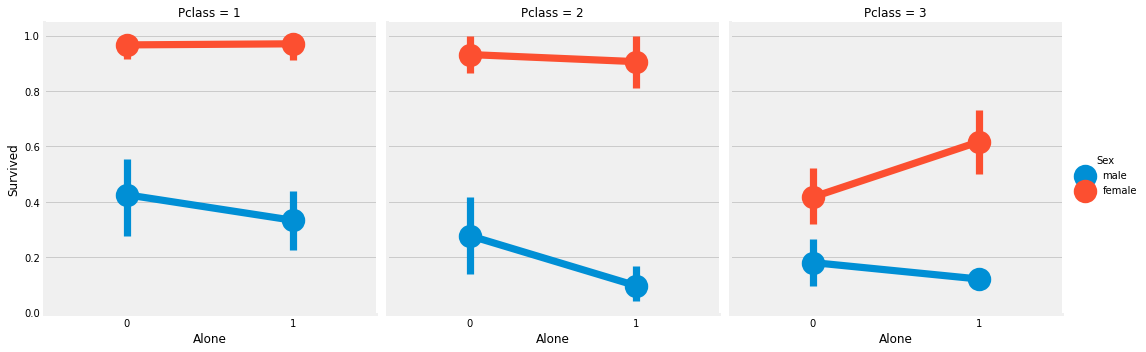

In [41]:
sns.factorplot('Alone', 'Survived', data=data, hue='Sex', col='Pclass')
plt.show()

혼자인 사람은 (Pclass3을 제외하고) 성별이나 Pclass에 상관없이 위험합니다. 여기서 혼자이면서 female인 사람의 생존 기회는 가족인 사람들보다 높습니다.

## Fare_Range

요금 또한 연속 feature이기 때문에, ordinal 범주형 값으로 변환할 필요가 있습니다. 이를 위해 pandas.qcut을 사용하겠습니다.

qcut이 무엇이냐면 우리가 전달하는 bins 갯수에 따라 값을 분리하고 배치하는 것입니다. 그래서 만일 우리가 5bins를 전달하면 값을 동등하게 5등분해서 배열합니다. 

In [42]:
data['Fare_Range'] = pd.qcut(data['Fare'], 4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


위에서 보이듯이, fare_range가 증가할수록 생존기회도 증가합니다. 

이제 우리는 Fare_Range 값을 지나칠 수 없습니다. 우리가 Age_Band에 했던 것처럼 단일 값으로 변경해야 합니다.

In [43]:
data['Fare_cat'] = 0
data.loc[data['Fare']<=7.91, 'Fare_cat'] = 0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454), 'Fare_cat'] = 1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31), 'Fare_cat'] = 2
data.loc[(data['Fare']>31)&(data['Fare']<=531), 'Fare_cat'] = 3

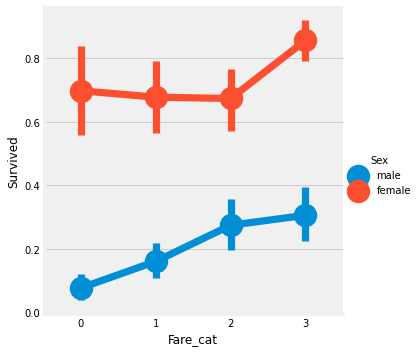

In [44]:
sns.factorplot('Fare_cat', 'Survived', data=data, hue='Sex')
plt.show()

명백하게 Fare_cat이 증가할수록 생존기회도 증가합니다. 이 feature는 성별과 함께 모델링을 할 때 중요한 feature가 될 겁니다. 

## 문자열 값을 숫자로 변환

머신러닝 모델에는 문자열을 통과시킬 수 없기 때문에 Sex, Embarked, 등등 feature들을 숫자형으로 변환해야 합니다.

In [45]:
data['Sex'].replace(['male', 'female'], [0,1], inplace=True)
data['Embarked'].replace(['S', 'C', 'Q'], [0,1,2], inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0,1,2,3,4], inplace=True)

### 불필요한 Feature들은 삭제

Name -> 카테고리형 값으로 변환할 수 없음

Age -> Age_band가 있어서 이건 불필요함

Ticket -> 랜덤 문자열임

Fare -> Fare_cat이 있어서 불필요함

Cabin -> NaN 값이 엄청 많음

Fare_Range -> fare_cat이 있음

PassengerId -> 범주화할 수 없음

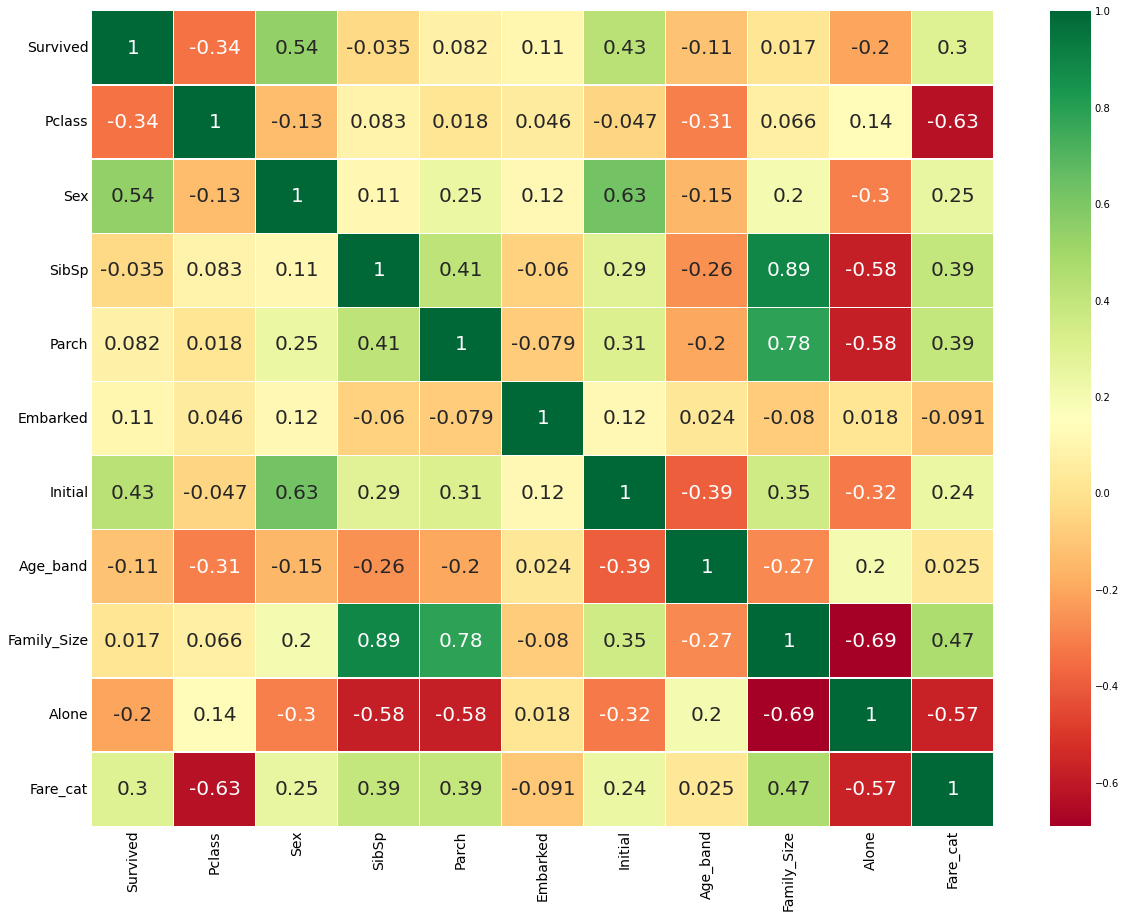

In [46]:
data.drop(['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Fare_Range', 'PassengerId'], axis=1, inplace=True)
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

위에 상관관계 그래프를 보면 양의 상관관계가 보이는 몇 feature들을 볼 수 있습니다. SipSp과 Family_size, Parch와 Family_size가 양의 상관관계를 보이고, 음의 상관관계는 Alone과 Family_size입니다.

# Part3: Predictive Modeling

우리는 EDA 파트에서 몇가지 인사이트를 얻었습니다. 그러나 그것만 가지고는 승객이 생존했는지 죽었는지를 정확히 예측하거나 말할 순 없습니다. 그래서 이제 승객이 생존했는지 아닌지 몇가지 뛰어난 분류 알고리즘을 사용해서 예측하려고 합니다. 다음의 알고리즘은 사용할 모델들입니다. 

1. Logistic Regression

2. Support Vector Machines (Linear and radial)

3. Random Forest

4. K-Nearest Neighbors

5. Naive Bayes

6. Decision Tree

7. Logistic Regression

In [47]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [48]:
train, test = train_test_split(data, test_size=0.3, random_state=0, stratify=data['Survived'])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]
X = data[data.columns[1:]]
Y = data['Survived']